# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.067357,False,0.014275
1,-0.036869,True,6.045405
2,-0.095574,False,0.542334
3,0.544641,True,5.552956
4,0.182090,True,5.263551
...,...,...,...
995,-0.173992,False,0.204965
996,0.773767,False,-0.349406
997,0.405403,False,-0.227146
998,0.889691,True,6.073794


<AxesSubplot: xlabel='v0'>

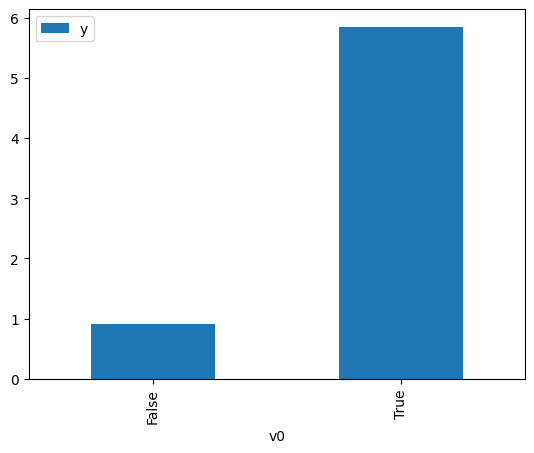

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

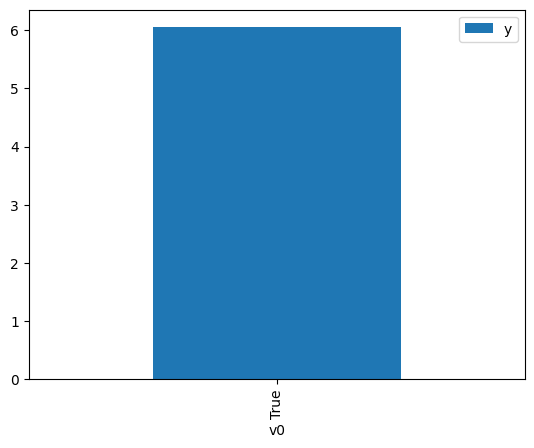

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.985194,False,-0.308022,0.348801,2.866960
1,1.830362,False,2.137125,0.204617,4.887182
2,1.676974,False,3.161788,0.227130,4.402758
3,0.852355,False,-0.061906,0.375418,2.663699
4,-0.324952,False,-2.414791,0.625401,1.598975
...,...,...,...,...,...
995,2.154110,False,4.898978,0.162654,6.148005
996,2.339651,False,3.631849,0.141899,7.047273
997,0.225454,False,0.837249,0.508733,1.965669
998,0.087394,False,0.862811,0.538606,1.856645


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.845319,True,5.065217,0.623150,1.604751
1,-0.273488,True,4.878179,0.385118,2.596604
2,-0.313955,True,5.056270,0.376838,2.653663
3,0.016784,True,4.404802,0.446208,2.241105
4,0.532792,True,4.664360,0.557680,1.793144
...,...,...,...,...,...
995,1.096505,True,5.802251,0.672805,1.486315
996,0.575558,True,6.353552,0.566813,1.764251
997,-0.686586,True,6.253208,0.304421,3.284928
998,2.546180,True,8.550852,0.878555,1.138233


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.273e+04
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                        0.00
Time:                        14:33:24   Log-Likelihood:                         -1408.5
No. Observations:                1000   AIC:                                      2821.
Df Residuals:                     998   BIC:                                      2831.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4441      0.034     42.509      0.000       1.377       1.511
x2             4.9808      0.053     94.411      0.000       4.877       5.084
==============================================================================
Omnibus:                        1.318   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.186
Skew:                          -0.070   Prob(JB):                        0.553
Kurtosis:                       3.094   Cond. No.                         2.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""